- Version: 1.0
- last update: 2023-12-09
- Short description: This notebook models causal inference for demographic variables using donor information.

## Install and Import

In [154]:
# Import modules
import numpy as np
import warnings
import os
from datetime import date
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

## Notebook Details

In [155]:
# parameters for logging and notebook exports
notebook_name = "03.02_causal_inference-modelling"  # only file name without extension

## Configuration

In [156]:
# Plotting
plt.rcParams["figure.figsize"] = (12, 8)
sns.set(rc={"figure.figsize": (12, 8)}, font_scale=0.8)
sns.set(style="darkgrid")

# Pandas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# Warnings
warnings.filterwarnings("ignore")

In [157]:
# Constants
ROOT_PATH = "../"
PATH_DATA = "data/"
PATH_DATA_RAW = "data/raw/"
PATH_DATA_INT = "data/interim/"
PATH_DATA_PRO = "data/processed/"
PATH_LOG = "logs/"
PATH_MOD = "models/"
PATH_REP = "reports/"
PATH_FIG = "reports/figures/"
PATH_HTML = "reports/html/"

# Set the seed for reproducibility
np.random.seed(42)

## Load Data

In [158]:
def load_data(path):
    return pd.read_parquet(ROOT_PATH + path)


file = "features_merged.parquet"
df = pd.read_parquet(ROOT_PATH + PATH_DATA_INT + file)

In [159]:
df.shape

(107, 148)

## Main Part

## Unadjusted model (group weights not considered)

In [160]:
columns_to_keep = [
    "age_clean",
    "sex_clean",
    "apo_e4_allele_clean",
    "cerad",
    "education_years",
    "education_years_stages_bin",
    "education_years_quartiles_bin",
    "age_at_first_tbi",
    "age_at_first_tbi_bin",
    "num_tbi_w_loc",
    "control_set",
    "ever_tbi_w_loc_clean",
    "longest_loc_duration_clean",
    #"longest_loc_duration",
    "longest_loc_duration_bin",
    "group_weight",
    "act_demented_clean",
]

# Subset the DataFrame
df_filtered = df[columns_to_keep]

In [161]:
print("Filtered DataFrame:")
df_filtered.info()

Filtered DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age_clean                      107 non-null    float64 
 1   sex_clean                      107 non-null    int64   
 2   apo_e4_allele_clean            107 non-null    int64   
 3   cerad                          107 non-null    int64   
 4   education_years                107 non-null    int64   
 5   education_years_stages_bin     107 non-null    category
 6   education_years_quartiles_bin  107 non-null    category
 7   age_at_first_tbi               107 non-null    int64   
 8   age_at_first_tbi_bin           107 non-null    object  
 9   num_tbi_w_loc                  107 non-null    int64   
 10  control_set                    107 non-null    int64   
 11  ever_tbi_w_loc_clean           107 non-null    int64   
 12  longest_loc_dura

In [162]:
# Filter out missing values for the variables of interest
df_unadjusted = df_filtered.dropna(subset=['act_demented_clean', 'ever_tbi_w_loc_clean'])

# Define the outcome and the treatment
outcome_unadjusted = df_unadjusted['act_demented_clean']
treatment_unadjusted = df_unadjusted['ever_tbi_w_loc_clean']

# Add a constant to the treatment for the intercept
treatment_unadjusted_with_const = sm.add_constant(treatment_unadjusted)

# Fit the logistic regression model for the unadjusted model (without group_weight)
unadjusted_model = sm.Logit(outcome_unadjusted, treatment_unadjusted_with_const)
unadjusted_results = unadjusted_model.fit()

# Display the summary of the unadjusted model
print(unadjusted_results.summary())

Optimization terminated successfully.
         Current function value: 0.689693
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:     act_demented_clean   No. Observations:                  107
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Dec 2023   Pseudo R-squ.:                0.001900
Time:                        21:39:03   Log-Likelihood:                -73.797
converged:                       True   LL-Null:                       -73.938
Covariance Type:            nonrobust   LLR p-value:                    0.5960
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2412      0.285     -0.846      0.397      -0.800       0.317

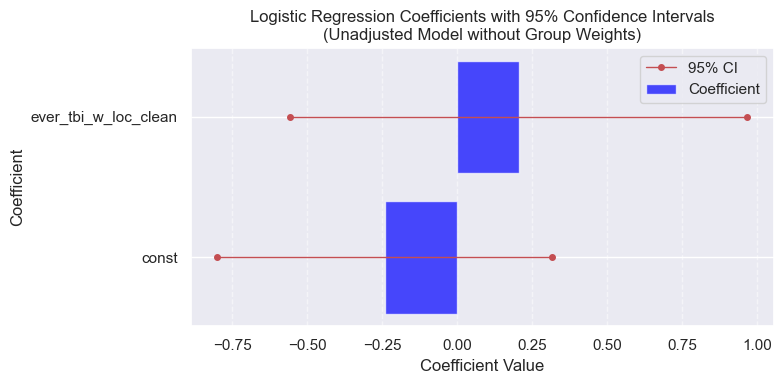

In [163]:
# Coefficients and standard errors
coefficients = unadjusted_results.params.values
std_errors = unadjusted_results.bse.values

# Variables
variables = unadjusted_results.params.index

# Confidence intervals (assuming 95% confidence)
confidence_intervals = [(c - 1.96 * se, c + 1.96 * se) for c, se in zip(coefficients, std_errors)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot coefficients as bars
ax.barh(variables, coefficients, color='blue', alpha=0.7, label='Coefficient')

# Plot confidence intervals as error bars
for i, (lower, upper) in enumerate(confidence_intervals):
    ax.plot([lower, upper], [i, i], 'ro-', markersize=4, linewidth=1, label='95% CI' if i == 0 else '')

# Add labels and title
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Coefficient')
ax.set_title('Logistic Regression Coefficients with 95% Confidence Intervals\n(Unadjusted Model without Group Weights)')
ax.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


**Interpretation:**
- The output presented is from a logistic regression analysis examining the relationship between the variable `ever_tbi_w_loc_clean` and the likelihood of being `act_demented_clean`. 
- The model, which includes 107 observations, uses Maximum Likelihood Estimation and converges in 4 iterations. The Pseudo R-squared value of 0.001900 indicates that the model explains very little of the variability in the dependent variable.
- The intercept of the model is not statistically significant, with a p-value of 0.397, suggesting that when `ever_tbi_w_loc_clean` is 0, the log odds of being `act_demented_clean` are not significantly different from zero. 
- The coefficient for `ever_tbi_w_loc_clean` is 0.2061, but it is also not statistically significant (p-value: 0.596), implying that changes in this predictor do not have a significant impact on the likelihood of being `act_demented_clean`. 
- The percentage change in odds for a one-unit increase in `ever_tbi_w_loc_clean` is approximately 22.89%, but due to the lack of statistical significance, this change should not be interpreted as a meaningful effect. 
- The overall fit of the model is weak, as suggested by the high p-value (0.5960) in the likelihood ratio test, indicating that adding `ever_tbi_w_loc_clean` as a predictor does not significantly improve the model compared to a null model with only an intercept.

## Unadjusted model (group weights considered)

In [164]:
# Filter out missing values for the variables of interest
df_weighted = df_filtered.dropna(subset=['act_demented_clean', 'ever_tbi_w_loc_clean', 'group_weight'])

# Define the outcome, the treatment, and the weights
outcome_weighted = df_weighted['act_demented_clean']
treatment_weighted = df_weighted['ever_tbi_w_loc_clean']
weights = df_weighted['group_weight']

# Add a constant to the treatment for the intercept
treatment_weighted_with_const = sm.add_constant(treatment_weighted)

# Fit the logistic regression model using GLM with a binomial family and frequency weights
weighted_model = sm.GLM(outcome_weighted, treatment_weighted_with_const, family=sm.families.Binomial(), var_weights=weights)
weighted_results = weighted_model.fit()

# Display the summary of the weighted unadjusted model
print(weighted_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     act_demented_clean   No. Observations:                  107
Model:                            GLM   Df Residuals:                      105
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2310.1
Date:                Sat, 09 Dec 2023   Deviance:                       4620.3
Time:                        21:39:03   Pearson chi2:                 3.97e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3663
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.1238 

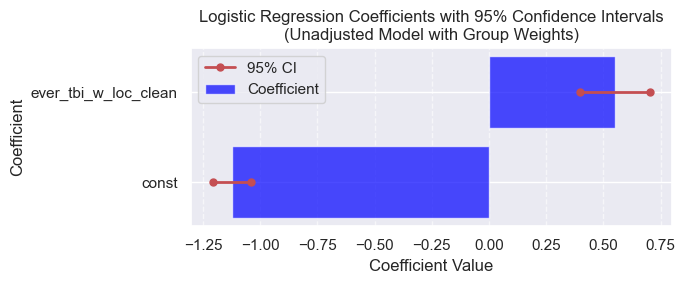

In [165]:
# Coefficients and standard errors
coefficients = weighted_results.params.values
std_errors = weighted_results.bse.values

# Variables
variables = weighted_results.params.index

# Confidence intervals (assuming 95% confidence)
confidence_intervals = [(c - 1.96 * se, c + 1.96 * se) for c, se in zip(coefficients, std_errors)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 3))

# Plot coefficients as bars
ax.barh(variables, coefficients, color='blue', alpha=0.7, label='Coefficient')

# Plot confidence intervals as error bars
for i, (lower, upper) in enumerate(confidence_intervals):
    ax.plot([lower, upper], [i, i], 'ro-', markersize=5, linewidth=2, label='95% CI' if i == 0 else '')

# Add labels and title
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Coefficient')
ax.set_title('Logistic Regression Coefficients with 95% Confidence Intervals\n(Unadjusted Model with Group Weights)')
ax.legend(loc='best')

# Show the plot
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [166]:
# Calculate odds ratios from the coefficients
odds_ratios = np.exp(weighted_results.params)

# Convert odds ratios to percentage impact
percent_impact = (odds_ratios - 1) * 100

# Print the results
print("Percentage Impact of Each Variable on the Outcome:")
for variable, impact in percent_impact.items():
    print(f"{variable}: {impact:.2f}%")

Percentage Impact of Each Variable on the Outcome:
const: -67.50%
ever_tbi_w_loc_clean: 73.70%


**Interpretation:**

1. **Dependent Variable and Model Details**:
- The dependent variable here is `act_demented_clean`.
- This analysis is based on 107 observations.
- The model used is a GLM with a binomial family, which is suitable for binary outcomes like dementia presence or absence.
- The link function is Logit, appropriate for binary logistic regression.

2. **Model Fit and Significance**:
   - The Pseudo R-squared (Comparative Fit Index) is 0.3663. This indicates the proportion of variance in the dependent variable that's explained by the model. A value of 0.3663 suggests a moderate fit.
   - The Log-Likelihood is -2310.1, which is a measure of the model’s goodness of fit.

3. **Coefficients**:
   - `const`: The coefficient for the constant (intercept) is -1.1238. This value represents the log odds of the outcome when all predictors are at their reference levels (in this case, when `ever_tbi_w_loc_clean` is 0).
   - `ever_tbi_w_loc_clean`: The coefficient is 0.5521. This means for every one-unit increase in `ever_tbi_w_loc_clean`, the log odds of being `act_demented_clean` increases by 0.5521, assuming other variables in the model are held constant.

4. **Standard Error and Z-Value**:
   - The standard errors for the intercept and `ever_tbi_w_loc_clean` are 0.043 and 0.078, respectively. These measure the variability or uncertainty in the coefficient estimates.
   - The z-values, which are the coefficients divided by their standard errors, are -26.299 for the intercept and 7.065 for `ever_tbi_w_loc_clean`. High absolute z-values suggest that the coefficients are significantly different from zero.

5. **P-Values**:
   - The P-values for both coefficients are less than 0.000, indicating that these effects are statistically significant.

6. **Confidence Intervals**:
   - The 95% confidence intervals for the coefficients provide a range of values within which the true population parameter likely falls. For `const`, it’s between -1.208 and -1.040, and for `ever_tbi_w_loc_clean`, it’s between 0.399 and 0.705.

7. **Percent Change Interpretation**:
   - To interpret the coefficient of `ever_tbi_w_loc_clean` in terms of percent change, we use the formula: \( \text{% change} = (e^{\text{coef}} - 1) \times 100 \% \).
   - Applying this to the `ever_tbi_w_loc_clean` coefficient: \( (e^{0.5521} - 1) \times 100 \% \).
   - The percent change associated with the `ever_tbi_w_loc_clean` coefficient is approximately 73.69%. This means that for every one-unit increase in `ever_tbi_w_loc_clean`, the odds of being `act_demented_clean` increase by about 73.69%, assuming other variables in the model are held constant.

8. **Summary**:
   - In summary, this GLM logistic regression model suggests a significant association between `ever_tbi_w_loc_clean` and the likelihood of being `act_demented_clean`, with a moderate fit to the data.


## Adjusted model (group weights not considered)

In [167]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age_clean                      107 non-null    float64 
 1   sex_clean                      107 non-null    int64   
 2   apo_e4_allele_clean            107 non-null    int64   
 3   cerad                          107 non-null    int64   
 4   education_years                107 non-null    int64   
 5   education_years_stages_bin     107 non-null    category
 6   education_years_quartiles_bin  107 non-null    category
 7   age_at_first_tbi               107 non-null    int64   
 8   age_at_first_tbi_bin           107 non-null    object  
 9   num_tbi_w_loc                  107 non-null    int64   
 10  control_set                    107 non-null    int64   
 11  ever_tbi_w_loc_clean           107 non-null    int64   
 12  longest_loc_duration_clean     107 n

In [168]:
df_adjusted = df_filtered[[
    'act_demented_clean',       # outcome
    'ever_tbi_w_loc_clean',     # treatment
    'age_clean',                # balanced
    'sex_clean',                # balanced
    'apo_e4_allele_clean',      # balanced
    'education_years',          # balanced
    #'cerad',                    # balanced, but post-mortem
    #'longest_loc_duration_clean',  # only minimal impact
    #'num_tbi_w_loc',               # only minimal impact
]]

# Dropping the records with the missing apo_e4_allele_clean values (-1)
df_adjusted = df_adjusted[~(df_adjusted == -1).any(axis=1)]
df_adjusted.shape

(100, 6)

In [169]:
# Define the outcome and the covariates
outcome_adjusted = df_adjusted['act_demented_clean']

covariates_adjusted = [
    'age_clean',
    'sex_clean',
    'apo_e4_allele_clean',
    'education_years',
    #'cerad',                       # balanced, but post-mortem
    'ever_tbi_w_loc_clean',
    #'longest_loc_duration_clean',  # only minimal impact
    #'num_tbi_w_loc',               # only minimal impact
]

In [170]:
# Add a constant to the covariates for the intercept
X_adjusted_with_const = sm.add_constant(df_adjusted[covariates_adjusted])

# Fit the logistic regression model for the adjusted model (without group_weight)
adjusted_model = sm.Logit(outcome_adjusted, X_adjusted_with_const)
adjusted_results = adjusted_model.fit()

# Display the summary of the adjusted model
print(adjusted_results.summary())

Optimization terminated successfully.
         Current function value: 0.640878
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:     act_demented_clean   No. Observations:                  100
Model:                          Logit   Df Residuals:                       94
Method:                           MLE   Df Model:                            5
Date:                Sat, 09 Dec 2023   Pseudo R-squ.:                 0.06868
Time:                        21:39:03   Log-Likelihood:                -64.088
converged:                       True   LL-Null:                       -68.814
Covariance Type:            nonrobust   LLR p-value:                   0.09233
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.8012      3.447      0.232      0.816      -5.955       7.558

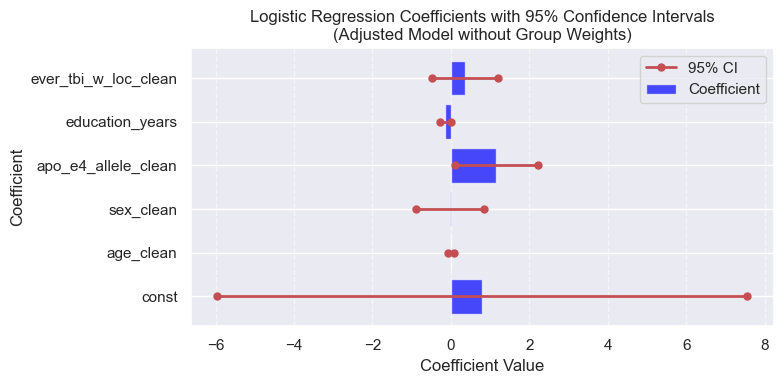

In [171]:
# Coefficients and standard errors
coefficients = adjusted_results.params.values
std_errors = adjusted_results.bse.values

# Variables
variables = adjusted_results.params.index

# Confidence intervals (assuming 95% confidence)
confidence_intervals = [(c - 1.96 * se, c + 1.96 * se) for c, se in zip(coefficients, std_errors)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot coefficients as bars
ax.barh(variables, coefficients, color='blue', alpha=0.7, label='Coefficient')

# Plot confidence intervals as error bars
for i, (lower, upper) in enumerate(confidence_intervals):
    ax.plot([lower, upper], [i, i], 'ro-', markersize=5, linewidth=2, label='95% CI' if i == 0 else '')

# Add labels and title
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Coefficient')
ax.set_title('Logistic Regression Coefficients with 95% Confidence Intervals\n(Adjusted Model without Group Weights)')
ax.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


## Adjusted model (group weights considered)

In [172]:
df_adjusted = df[[
    'act_demented_clean',           # outcome
    'ever_tbi_w_loc_clean',         # treatment
    'age_clean',                    # balanced
    'sex_clean',                    # balanced
    'apo_e4_allele_clean',          # balanced
    'education_years',              # balanced
    #'cerad',                        # # balanced, but post-mortem
    #'age_at_first_tbi',             # only minimal impact
    #'longest_loc_duration_clean',   # only minimal impact
    #'num_tbi_w_loc',                # only minimal impact
    'group_weight',
]]

# Dropping the records with the missing apo_e4_allele_clean values (-1)
df_adjusted = df_adjusted[~(df_adjusted == -1).any(axis=1)]

# Define the outcome and the covariates
outcome_adjusted = df_adjusted['act_demented_clean']

covariates_adjusted = list(df_adjusted.drop(columns=['act_demented_clean', 'group_weight']).columns)

print("Covariates adjusted (selected columns):")
covariates_adjusted

Covariates adjusted (selected columns):


['ever_tbi_w_loc_clean',
 'age_clean',
 'sex_clean',
 'apo_e4_allele_clean',
 'education_years']

In [173]:
# Add a constant to the covariates for the intercept
X_adjusted_with_const = sm.add_constant(df_adjusted[covariates_adjusted])

# Fit the logistic regression model using GLM with a binomial family and frequency weights
adjusted_model_with_weights = sm.GLM(outcome_adjusted, X_adjusted_with_const, family=sm.families.Binomial(), var_weights=df_adjusted['group_weight'])
adjusted_results_with_weights = adjusted_model_with_weights.fit()

# Display the summary of the adjusted model with weights
print(adjusted_results_with_weights.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     act_demented_clean   No. Observations:                  100
Model:                            GLM   Df Residuals:                       94
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1728.0
Date:                Sat, 09 Dec 2023   Deviance:                       3456.0
Time:                        21:39:03   Pearson chi2:                 3.67e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9989
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.2607 

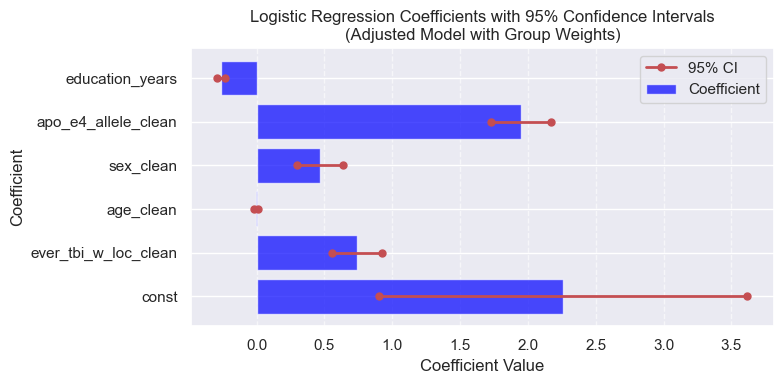

In [174]:
# Coefficients and standard errors
coefficients = adjusted_results_with_weights.params.values
std_errors = adjusted_results_with_weights.bse.values

# Variables
variables = adjusted_results_with_weights.params.index

# Confidence intervals (assuming 95% confidence)
confidence_intervals = [(c - 1.96 * se, c + 1.96 * se) for c, se in zip(coefficients, std_errors)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot coefficients as bars
ax.barh(variables, coefficients, color='blue', alpha=0.7, label='Coefficient')

# Plot confidence intervals as error bars
for i, (lower, upper) in enumerate(confidence_intervals):
    ax.plot([lower, upper], [i, i], 'ro-', markersize=5, linewidth=2, label='95% CI' if i == 0 else '')

# Add labels and title
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Coefficient')
ax.set_title('Logistic Regression Coefficients with 95% Confidence Intervals\n(Adjusted Model with Group Weights)')
ax.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


### Adjusted model with all variables (group weights considered)

In [175]:
df_adjusted = df[[
    'act_demented_clean',       # outcome
    'ever_tbi_w_loc_clean',     # treatment
    'age_clean',                # balanced
    'sex_clean',                # balanced
    'apo_e4_allele_clean',      # balanced
    'education_years',          # balanced
    #'cerad',                    # balanced, but post-mortem
    'age_at_first_tbi',             # only minimal impact
    'longest_loc_duration_clean',   # only minimal impact
    #'num_tbi_w_loc',                # only minimal impact: should not be used, because very unbalanced: 1 time TBI with 45 donors vs > 1 TBI with 9 donors 
    'group_weight',
]]

# Dropping the records with the missing apo_e4_allele_clean values (-1)
df_adjusted = df_adjusted[~(df_adjusted == -1).any(axis=1)]

# Define the outcome and the covariates
outcome_adjusted = df_adjusted['act_demented_clean']

covariates_adjusted = list(df_adjusted.drop(columns=['act_demented_clean', 'group_weight']).columns)

print("Covariates adjusted (selected columns):")
covariates_adjusted

Covariates adjusted (selected columns):


['ever_tbi_w_loc_clean',
 'age_clean',
 'sex_clean',
 'apo_e4_allele_clean',
 'education_years',
 'age_at_first_tbi',
 'longest_loc_duration_clean']

In [176]:
# Add a constant to the covariates for the intercept
X_adjusted_with_const = sm.add_constant(df_adjusted[covariates_adjusted])

# Fit the logistic regression model using GLM with a binomial family and frequency weights
adjusted_model_with_weights = sm.GLM(outcome_adjusted, X_adjusted_with_const, family=sm.families.Binomial(), var_weights=df_adjusted['group_weight'])
adjusted_results_with_weights = adjusted_model_with_weights.fit()

# Display the summary of the adjusted model with weights
print(adjusted_results_with_weights.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:     act_demented_clean   No. Observations:                   93
Model:                            GLM   Df Residuals:                       85
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1625.2
Date:                Sat, 09 Dec 2023   Deviance:                       3250.4
Time:                        21:39:03   Pearson chi2:                 3.60e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9988
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## Adjusted model with all pre-mortality variables (group weights considered and using binned attributes)

In [177]:
df_adjusted = df[[
    'act_demented_clean',        # outcome
    'ever_tbi_w_loc_clean',      # treatment
    #'age_clean',                # balanced: removed because age of death
    'sex_clean',                 # balanced
    'apo_e4_allele_clean',       # balanced
    #'cerad',                     # balanced, but post-mortem
    'education_years_stages_bin',
    'age_at_first_tbi_bin',      
    'longest_loc_duration_bin',
    #'num_tbi_w_loc',                # should not be used, because very unbalanced: 1 time TBI with 45 donors vs > 1 TBI with 9 donors 
    'group_weight',
]]

# Dropping the records with the missing apo_e4_allele_clean values (-1)
df_adjusted = df_adjusted[~(df_adjusted == -1).any(axis=1)]

# Define the outcome and the covariates
outcome_adjusted = df_adjusted['act_demented_clean']

covariates_adjusted = list(df_adjusted.drop(columns=['act_demented_clean', 'group_weight']).columns)

print("Adjusted covariates (selected columns), with a focus on attributes prior to mortality:")
set(covariates_adjusted)

Adjusted covariates (selected columns), with a focus on attributes prior to mortality:


{'age_at_first_tbi_bin',
 'apo_e4_allele_clean',
 'education_years_stages_bin',
 'ever_tbi_w_loc_clean',
 'longest_loc_duration_bin',
 'sex_clean'}

In [178]:
# Create a label encoder object
le = LabelEncoder()

# Apply label encoding on 'longest_loc_duration_clean' and 'age_at_first_tbi'
df_adjusted['longest_loc_duration_bin'] = le.fit_transform(df_adjusted['longest_loc_duration_bin'])
df_adjusted['age_at_first_tbi_bin'] = le.fit_transform(df_adjusted['age_at_first_tbi_bin'])
df_adjusted['education_years_stages_bin'] = le.fit_transform(df_adjusted['education_years_stages_bin'])

#df_adjusted.head()

In [179]:
# Add a constant to the covariates for the intercept
X_adjusted_with_const = sm.add_constant(df_adjusted[covariates_adjusted])

# Fit the logistic regression model using GLM with a binomial family and frequency weights
adjusted_model_with_weights = sm.GLM(outcome_adjusted, X_adjusted_with_const, family=sm.families.Binomial(), var_weights=df_adjusted['group_weight'])
adjusted_results_with_weights = adjusted_model_with_weights.fit()

# Display the summary of the adjusted model with weights
print(adjusted_results_with_weights.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     act_demented_clean   No. Observations:                  100
Model:                            GLM   Df Residuals:                       93
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1865.0
Date:                Sat, 09 Dec 2023   Deviance:                       3729.9
Time:                        21:39:03   Pearson chi2:                 3.75e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9828
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

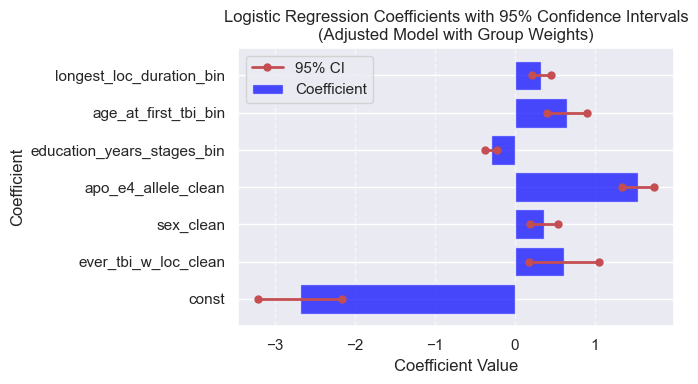

In [180]:
# Coefficients and standard errors
coefficients = adjusted_results_with_weights.params.values
std_errors = adjusted_results_with_weights.bse.values

# Variables
variables = adjusted_results_with_weights.params.index

# Confidence intervals (assuming 95% confidence)
confidence_intervals = [(c - 1.96 * se, c + 1.96 * se) for c, se in zip(coefficients, std_errors)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 4))

# Plot coefficients as bars
ax.barh(variables, coefficients, color='blue', alpha=0.7, label='Coefficient')

# Plot confidence intervals as error bars
for i, (lower, upper) in enumerate(confidence_intervals):
    ax.plot([lower, upper], [i, i], 'ro-', markersize=5, linewidth=2, label='95% CI' if i == 0 else '')

# Add labels and title
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Coefficient')
ax.set_title('Logistic Regression Coefficients with 95% Confidence Intervals\n(Adjusted Model with Group Weights)')
ax.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [181]:
# Calculate odds ratios from the coefficients
odds_ratios = np.exp(adjusted_results_with_weights.params)

# Convert odds ratios to percentage impact
percent_impact = (odds_ratios - 1) * 100

# Print the results
print("Percentage Impact of Each Variable on the Outcome:")
for variable, impact in percent_impact.items():
    print(f"{variable}: {impact:.2f}%")

Percentage Impact of Each Variable on the Outcome:
const: -93.21%
ever_tbi_w_loc_clean: 84.71%
sex_clean: 44.13%
apo_e4_allele_clean: 367.18%
education_years_stages_bin: -26.22%
age_at_first_tbi_bin: 90.90%
longest_loc_duration_bin: 39.42%


**Interpretation:**

1. **Model Performance Metrics**: 
   - **Log-Likelihood**: The log-likelihood of the model is -1865.0, which is a measure of the fit of the model. In isolation, this number doesn't mean much, but it's useful for comparing models.
   - **Deviance**: The model's deviance is 3729.9, indicating the goodness of fit. Lower deviance indicates a better fit.
   - **Pseudo R-squared**: The Pseudo R-squared value of 0.9828 suggests that the model explains a high proportion of the variance in the outcome.

2. **Coefficients**:
   - **Constant**: The coefficient for the constant term is -2.6894, representing the log odds of being diagnosed with dementia when all other variables are zero.
   - **ever_tbi_w_loc_clean**: With a coefficient of 0.6136, this suggests that each unit increase in traumatic brain injury with loss of consciousness is associated with higher odds of dementia.
   - **sex_clean**: The coefficient of 0.3655 for being male indicates a positive association with the odds of dementia.
   - **apo_e4_allele_clean**: This has a high coefficient of 1.5415, indicating a strong association with increased odds of dementia.
   - **education_years_stages_bin**: A negative coefficient of -0.3041 suggests that higher education levels are associated with lower odds of dementia.
   - **age_at_first_tbi_bin** and **longest_loc_duration_bin**: Coefficients of 0.6466 and 0.3323 respectively suggest that both older age at first TBI and longer duration of loss of consciousness are associated with increased odds of dementia.

3. **Statistical Significance**: All predictor variables have p-values less than 0.05, indicating that their effects are statistically significant.

### Addressing Overfitting

When analyzing the initial GLM model, we noted that it reported a Pseudo R-squared of 0.9828. This value is unusually high for logistic regression models, especially given our modest sample size of 100 observations. A Pseudo R-squared of this magnitude often suggests overfitting. Overfitting occurs when a model captures noise as if it were a significant pattern, leading to poor performance on new, unseen data.

To address this concern and to validate our insights, we collectively took the following steps in our analysis:

- **Data Preprocessing:** We chose not to directly incorporate 'group_weights' into our modeling process. Instead, we expanded the dataset by duplicating records according to their respective rounded 'group_weight'. This step was crucial in balancing the dataset, making it more reflective of the real-world distribution and ensuring a more robust analysis.

- **Modeling with sm.Logit:** We applied a logistic regression model using sm.Logit from the statsmodels library. This method allowed us to calculate the coefficients and p-values for each predictor, providing us with a statistical foundation to gauge their impact on our outcome variable, 'act_demented_clean'.

- **Comparative Analysis with sm.GLM:** We compared the results from sm.Logit with those obtained from a Generalized Linear Model (GLM) using the same library. This comparative analysis was instrumental in assessing the consistency and reliability of our findings across different modeling techniques.

- **Interpreting the Coefficients:** To make our results more accessible and interpretable, we calculated the percentage changes associated with each predictor. These percentages illustrate how the odds of the outcome, 'act_demented_clean', change with a one-unit alteration in each predictor. This step was vital in translating the logistic regression coefficients into a more understandable format.

In [182]:
# Python code to prepare and duplicate the records based on the weights

# Rounding the group weights
df['group_weight_rounded'] = df['group_weight'].round().astype(int)

# Replicating rows based on the rounded group weight
df_weighted = df.loc[np.repeat(df.index, df['group_weight_rounded'])]

# Dropping the 'group_weight_rounded' column as it's no longer needed
df_weighted = df_weighted.drop(columns=['group_weight_rounded'])

# The df_weighted dataframe now contains duplicated records based on the weights
df_weighted.head()  # Displaying the first few rows of the adjusted dataframe

,donor_id,name,age,sex,apo_e4_allele,education_years,age_at_first_tbi,longest_loc_duration,cerad,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan,age_bin,age_clean,age_at_first_tbi_bin,education_years_stages_bin,education_years_quartiles_bin,longest_loc_duration_bin,longest_loc_duration_clean,act_demented_clean,sex_clean,apo_e4_allele_clean,ever_tbi_w_loc_clean,group_weight,ihc_a_syn_FWM,ihc_a_syn_HIP,ihc_a_syn_PCx,ihc_a_syn_TCx,ihc_tau2_ffpe_FWM,ihc_tau2_ffpe_HIP,ihc_tau2_ffpe_PCx,ihc_tau2_ffpe_TCx,ihc_at8_ffpe_FWM,ihc_at8_ffpe_HIP,ihc_at8_ffpe_PCx,ihc_at8_ffpe_TCx,ihc_at8_FWM,ihc_at8_HIP,ihc_at8_PCx,ihc_at8_TCx,ihc_ptdp_43_ffpe_FWM,ihc_ptdp_43_ffpe_HIP,ihc_ptdp_43_ffpe_PCx,ihc_ptdp_43_ffpe_TCx,ihc_a_beta_ffpe_FWM,ihc_a_beta_ffpe_HIP,ihc_a_beta_ffpe_PCx,ihc_a_beta_ffpe_TCx,ihc_a_beta_FWM,ihc_a_beta_HIP,ihc_a_beta_PCx,ihc_a_beta_TCx,ihc_iba1_ffpe_FWM,ihc_iba1_ffpe_HIP,ihc_iba1_ffpe_PCx,ihc_iba1_ffpe_TCx,ihc_gfap_ffpe_FWM,ihc_gfap_ffpe_HIP,ihc_gfap_ffpe_PCx,ihc_gfap_ffpe_TCx,ptau_ng_per_mg_FWM,ptau_ng_per_mg_HIP,ptau_ng_per_mg_PCx,ptau_ng_per_mg_TCx,vegf_pg_per_mg_FWM,vegf_pg_per_mg_HIP,vegf_pg_per_mg_PCx,vegf_pg_per_mg_TCx,ab42_over_ab40_ratio_FWM,ab42_over_ab40_ratio_HIP,ab42_over_ab40_ratio_PCx,ab42_over_ab40_ratio_TCx,tnf_a_pg_per_mg_FWM,tnf_a_pg_per_mg_HIP,tnf_a_pg_per_mg_PCx,tnf_a_pg_per_mg_TCx,tau_ng_per_mg_FWM,tau_ng_per_mg_HIP,tau_ng_per_mg_PCx,tau_ng_per_mg_TCx,il_10_pg_per_mg_FWM,il_10_pg_per_mg_HIP,il_10_pg_per_mg_PCx,il_10_pg_per_mg_TCx,isoprostane_pg_per_mg_FWM,isoprostane_pg_per_mg_HIP,isoprostane_pg_per_mg_PCx,isoprostane_pg_per_mg_TCx,il_6_pg_per_mg_FWM,il_6_pg_per_mg_HIP,il_6_pg_per_mg_PCx,il_6_pg_per_mg_TCx,il_1b_pg_per_mg_FWM,il_1b_pg_per_mg_HIP,il_1b_pg_per_mg_PCx,il_1b_pg_per_mg_TCx,ptau_over_tau_ratio_FWM,ptau_over_tau_ratio_HIP,ptau_over_tau_ratio_PCx,ptau_over_tau_ratio_TCx,il_4_pg_per_mg_FWM,il_4_pg_per_mg_HIP,il_4_pg_per_mg_PCx,il_4_pg_per_mg_TCx,rantes_pg_per_mg_FWM,rantes_pg_per_mg_HIP,rantes_pg_per_mg_PCx,rantes_pg_per_mg_TCx,ab40_pg_per_mg_FWM,ab40_pg_per_mg_HIP,ab40_pg_per_mg_PCx,ab40_pg_per_mg_TCx,a_syn_pg_per_mg_FWM,a_syn_pg_per_mg_HIP,a_syn_pg_per_mg_PCx,a_syn_pg_per_mg_TCx,ifn_g_pg_per_mg_FWM,ifn_g_pg_per_mg_HIP,ifn_g_pg_per_mg_PCx,ifn_g_pg_per_mg_TCx,mcp_1_pg_per_mg_FWM,mcp_1_pg_per_mg_HIP,mcp_1_pg_per_mg_PCx,mcp_1_pg_per_mg_TCx,bdnf_pg_per_mg_FWM,bdnf_pg_per_mg_HIP,bdnf_pg_per_mg_PCx,bdnf_pg_per_mg_TCx,mip_1a_pg_per_mg_FWM,mip_1a_pg_per_mg_HIP,mip_1a_pg_per_mg_PCx,mip_1a_pg_per_mg_TCx,il_7_pg_per_mg_FWM,il_7_pg_per_mg_HIP,il_7_pg_per_mg_PCx,il_7_pg_per_mg_TCx,ab42_pg_per_mg_FWM,ab42_pg_per_mg_HIP,ab42_pg_per_mg_PCx,ab42_pg_per_mg_TCx,total_scan
0,326765665,H14.09.078,87,M,N,16,0,Unknown or N/A,0,0,No Dementia,31,No Dementia,N,White,Not Hispanic,No Dementia,1,1,87-89,87.0,NA,16-18 years,14-16 years,Unknown or N/A,0.0,0,1,0,0,47.75,-1.0,0.000046,-1.0,0.000056,-1.0,0.003905,-1.0,0.003677,-1.0,0.013143,-1.0,0.001854,-1.0,0.012439,-1.0,0.000061,-1.0,0.001035,-1.0,0.001987,-1.0,0.008041,-1.0,0.006379,-1.0,0.007813,-1.0,0.00181,-1.0,0.045469,-1.0,0.025448,-1.0,0.064207,-1.0,-1.0,-1.0,0.746922,-1.0,0.121403,-1.0,0.0,-1.0,1.64,-1.0,0.182779,-1.0,27.658229,-1.0,8.1,-1.0,0.8,-1.0,1.28179,-1.0,1.66869,-1.0,0.0,-1.0,0.12,-1.0,-1.0,-1.0,2.664223,-1.0,74.04,-1.0,0.94,-1.0,0.24,-1.0,0.0,-1.0,0.582718,-1.0,0.072753,-1.0,0.0,-1.0,1.6,-1.0,12.78,-1.0,81.88,-1.0,0.545775,-1.0,0.157781,-1.0,0.296666,-1.0,0.18,-1.0,1.94,-1.0,0.84,-1.0,0.58,-1.0,18.68,-1.0,4.03619,-1.0,0.18,-1.0,3.7,-1.0,15.38,-1.0,0.6,-1.0,11.0,-1.0,0.099756,-1.0,4.36395,2
0,326765665,H14.09.078,87,M,N,16,0,Unknown or N/A,0,0,No Dementia,31,No Dementia,N,White,Not Hispanic,No Dementia,1,1,87-89,87.0,NA,16-18 years,14-16 years,Unknown or N/A,0.0,0,1,0,0,47.75,-1.0,0.000046,-1.0,0.000056,-1.0,0.003905,-1.0,0.003677,-1.0,0.013143,-1.0,0.001854,-1.0,0.012439,-1.0,0.000061,-1.0,0.001035,-1.0,0.001987,-1.0,0.008041,-1.0,0.006379,-1.0,0.007813,-1.0,0.00181,-1.0,0.045469

In [183]:
df_weighted.shape

(3969, 148)

In [184]:
# Adjusting the dataframe by dropping records with missing 'apo_e4_allele_clean' values
df_weighted_clean = df_weighted[df_weighted['apo_e4_allele_clean'] != -1]

# Applying label encoding only to specific columns
le = LabelEncoder()
df_weighted_clean['longest_loc_duration_bin'] = le.fit_transform(df_weighted_clean['longest_loc_duration_bin'])
df_weighted_clean['age_at_first_tbi_bin'] = le.fit_transform(df_weighted_clean['age_at_first_tbi_bin'])
df_weighted_clean['education_years_stages_bin'] = le.fit_transform(df_weighted_clean['education_years_stages_bin'])

# Verifying the dataframe after label encoding
df_weighted_clean.head()

,donor_id,name,age,sex,apo_e4_allele,education_years,age_at_first_tbi,longest_loc_duration,cerad,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan,age_bin,age_clean,age_at_first_tbi_bin,education_years_stages_bin,education_years_quartiles_bin,longest_loc_duration_bin,longest_loc_duration_clean,act_demented_clean,sex_clean,apo_e4_allele_clean,ever_tbi_w_loc_clean,group_weight,ihc_a_syn_FWM,ihc_a_syn_HIP,ihc_a_syn_PCx,ihc_a_syn_TCx,ihc_tau2_ffpe_FWM,ihc_tau2_ffpe_HIP,ihc_tau2_ffpe_PCx,ihc_tau2_ffpe_TCx,ihc_at8_ffpe_FWM,ihc_at8_ffpe_HIP,ihc_at8_ffpe_PCx,ihc_at8_ffpe_TCx,ihc_at8_FWM,ihc_at8_HIP,ihc_at8_PCx,ihc_at8_TCx,ihc_ptdp_43_ffpe_FWM,ihc_ptdp_43_ffpe_HIP,ihc_ptdp_43_ffpe_PCx,ihc_ptdp_43_ffpe_TCx,ihc_a_beta_ffpe_FWM,ihc_a_beta_ffpe_HIP,ihc_a_beta_ffpe_PCx,ihc_a_beta_ffpe_TCx,ihc_a_beta_FWM,ihc_a_beta_HIP,ihc_a_beta_PCx,ihc_a_beta_TCx,ihc_iba1_ffpe_FWM,ihc_iba1_ffpe_HIP,ihc_iba1_ffpe_PCx,ihc_iba1_ffpe_TCx,ihc_gfap_ffpe_FWM,ihc_gfap_ffpe_HIP,ihc_gfap_ffpe_PCx,ihc_gfap_ffpe_TCx,ptau_ng_per_mg_FWM,ptau_ng_per_mg_HIP,ptau_ng_per_mg_PCx,ptau_ng_per_mg_TCx,vegf_pg_per_mg_FWM,vegf_pg_per_mg_HIP,vegf_pg_per_mg_PCx,vegf_pg_per_mg_TCx,ab42_over_ab40_ratio_FWM,ab42_over_ab40_ratio_HIP,ab42_over_ab40_ratio_PCx,ab42_over_ab40_ratio_TCx,tnf_a_pg_per_mg_FWM,tnf_a_pg_per_mg_HIP,tnf_a_pg_per_mg_PCx,tnf_a_pg_per_mg_TCx,tau_ng_per_mg_FWM,tau_ng_per_mg_HIP,tau_ng_per_mg_PCx,tau_ng_per_mg_TCx,il_10_pg_per_mg_FWM,il_10_pg_per_mg_HIP,il_10_pg_per_mg_PCx,il_10_pg_per_mg_TCx,isoprostane_pg_per_mg_FWM,isoprostane_pg_per_mg_HIP,isoprostane_pg_per_mg_PCx,isoprostane_pg_per_mg_TCx,il_6_pg_per_mg_FWM,il_6_pg_per_mg_HIP,il_6_pg_per_mg_PCx,il_6_pg_per_mg_TCx,il_1b_pg_per_mg_FWM,il_1b_pg_per_mg_HIP,il_1b_pg_per_mg_PCx,il_1b_pg_per_mg_TCx,ptau_over_tau_ratio_FWM,ptau_over_tau_ratio_HIP,ptau_over_tau_ratio_PCx,ptau_over_tau_ratio_TCx,il_4_pg_per_mg_FWM,il_4_pg_per_mg_HIP,il_4_pg_per_mg_PCx,il_4_pg_per_mg_TCx,rantes_pg_per_mg_FWM,rantes_pg_per_mg_HIP,rantes_pg_per_mg_PCx,rantes_pg_per_mg_TCx,ab40_pg_per_mg_FWM,ab40_pg_per_mg_HIP,ab40_pg_per_mg_PCx,ab40_pg_per_mg_TCx,a_syn_pg_per_mg_FWM,a_syn_pg_per_mg_HIP,a_syn_pg_per_mg_PCx,a_syn_pg_per_mg_TCx,ifn_g_pg_per_mg_FWM,ifn_g_pg_per_mg_HIP,ifn_g_pg_per_mg_PCx,ifn_g_pg_per_mg_TCx,mcp_1_pg_per_mg_FWM,mcp_1_pg_per_mg_HIP,mcp_1_pg_per_mg_PCx,mcp_1_pg_per_mg_TCx,bdnf_pg_per_mg_FWM,bdnf_pg_per_mg_HIP,bdnf_pg_per_mg_PCx,bdnf_pg_per_mg_TCx,mip_1a_pg_per_mg_FWM,mip_1a_pg_per_mg_HIP,mip_1a_pg_per_mg_PCx,mip_1a_pg_per_mg_TCx,il_7_pg_per_mg_FWM,il_7_pg_per_mg_HIP,il_7_pg_per_mg_PCx,il_7_pg_per_mg_TCx,ab42_pg_per_mg_FWM,ab42_pg_per_mg_HIP,ab42_pg_per_mg_PCx,ab42_pg_per_mg_TCx,total_scan
0,326765665,H14.09.078,87,M,N,16,0,Unknown or N/A,0,0,No Dementia,31,No Dementia,N,White,Not Hispanic,No Dementia,1,1,87-89,87.0,0,2,14-16 years,4,0.0,0,1,0,0,47.75,-1.0,0.000046,-1.0,0.000056,-1.0,0.003905,-1.0,0.003677,-1.0,0.013143,-1.0,0.001854,-1.0,0.012439,-1.0,0.000061,-1.0,0.001035,-1.0,0.001987,-1.0,0.008041,-1.0,0.006379,-1.0,0.007813,-1.0,0.00181,-1.0,0.045469,-1.0,0.025448,-1.0,0.064207,-1.0,-1.0,-1.0,0.746922,-1.0,0.121403,-1.0,0.0,-1.0,1.64,-1.0,0.182779,-1.0,27.658229,-1.0,8.1,-1.0,0.8,-1.0,1.28179,-1.0,1.66869,-1.0,0.0,-1.0,0.12,-1.0,-1.0,-1.0,2.664223,-1.0,74.04,-1.0,0.94,-1.0,0.24,-1.0,0.0,-1.0,0.582718,-1.0,0.072753,-1.0,0.0,-1.0,1.6,-1.0,12.78,-1.0,81.88,-1.0,0.545775,-1.0,0.157781,-1.0,0.296666,-1.0,0.18,-1.0,1.94,-1.0,0.84,-1.0,0.58,-1.0,18.68,-1.0,4.03619,-1.0,0.18,-1.0,3.7,-1.0,15.38,-1.0,0.6,-1.0,11.0,-1.0,0.099756,-1.0,4.36395,2
0,326765665,H14.09.078,87,M,N,16,0,Unknown or N/A,0,0,No Dementia,31,No Dementia,N,White,Not Hispanic,No Dementia,1,1,87-89,87.0,0,2,14-16 years,4,0.0,0,1,0,0,47.75,-1.0,0.000046,-1.0,0.000056,-1.0,0.003905,-1.0,0.003677,-1.0,0.013143,-1.0,0.001854,-1.0,0.012439,-1.0,0.000061,-1.0,0.001035,-1.0,0.001987,-1.0,0.008041,-1.0,0.006379,-1.0,0.007813,-1.0,0.00181,-1.0,0.045469,-1.0,0.025448,-1.0,0.064207,-1.0,-1.0,-1.0,0.74

In [185]:
# Selecting the covariates for the logistic regression model
covariates = ['ever_tbi_w_loc_clean', 'sex_clean', 'apo_e4_allele_clean', 
              'education_years_stages_bin', 'age_at_first_tbi_bin', 'longest_loc_duration_bin']

# Creating a copy of the df_weighted for label encoding
df_label_encoded = df_weighted_clean.copy()

# Initializing label encoders for categorical columns
label_encoders = {col: LabelEncoder() for col in covariates if df_label_encoded[col].dtype == 'object'}

# Applying label encoding to each categorical column
for col, le in label_encoders.items():
    df_label_encoded[col] = le.fit_transform(df_label_encoded[col])

# Preparing the data for logistic regression
X_label_encoded = df_label_encoded[covariates]  # Covariates with label encoding
y_label_encoded = df_label_encoded['act_demented_clean']  # Outcome variable

# Adding a constant to the model (for the intercept)
X_const_label_encoded = sm.add_constant(X_label_encoded)

# Fitting the logistic regression model with label encoded data
model_label_encoded = sm.Logit(y_label_encoded, X_const_label_encoded)
result_label_encoded = model_label_encoded.fit()

# Getting the summary of the model
model_summary_label_encoded = result_label_encoded.summary()
model_summary_label_encoded

Optimization terminated successfully.
         Current function value: 0.506600
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     act_demented_clean   No. Observations:                 3672
Model:                          Logit   Df Residuals:                     3665
Method:                           MLE   Df Model:                            6
Date:                Sat, 09 Dec 2023   Pseudo R-squ.:                 0.09959
Time:                        21:39:04   Log-Likelihood:                -1860.2
converged:                       True   LL-Null:                       -2066.0
Covariance Type:            nonrobust   LLR p-value:                 9.337e-86
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.6530      0.267     -9.954      0.000      -3.175      -2.131
ever_tbi_w_loc_clean           0.6046      0.222      2.728      0.006       0.170       1.039
sex_clean                      0.3683      0.089      4.160      0.000       0.195       0.542
apo_e4_allele_clean            1.5550      0.103     15.169      0.000       1.354       1.756
education_years_stages_bin    -0.3103      0.038     -8.146      0.000      -0.385      -0.236
age_at_first_tbi_bin           0.6430      0.127      5.043      0.000       0.393       0.893
longest_loc_duration_bin       0.3233      0.062      5.219      0.000       0.202       0.445
==============================================================================================
"""

In [186]:
# Calculate odds ratios from the coefficients
odds_ratios = np.exp(result_label_encoded.params)

# Convert odds ratios to percentage impact
percent_impact = (odds_ratios - 1) * 100

# Print the results
print("Percentage Impact of Each Variable on the Outcome:")
for variable, impact in percent_impact.items():
    print(f"{variable}: {impact:.2f}%")

Percentage Impact of Each Variable on the Outcome:
const: -92.96%
ever_tbi_w_loc_clean: 83.06%
sex_clean: 44.52%
apo_e4_allele_clean: 373.50%
education_years_stages_bin: -26.68%
age_at_first_tbi_bin: 90.21%
longest_loc_duration_bin: 38.17%


**Interpretation:**

- **Dependent Variable (`act_demented_clean`)**: This is what the model is trying to predict – whether or not an individual is diagnosed with dementia.

- **Number of Observations (3672)**: This represents the total number of data points included in the model.

- **Method (MLE)**: The model is estimated using Maximum Likelihood Estimation.

- **Pseudo R-squared (0.09959)**: This is a measure of the goodness of fit of the model. A value of 0.09959 suggests that the model explains approximately 9.96% of the variability in the dependent variable.

- **Log-Likelihood (-1860.2)**: This is the log-likelihood of the model, a measure of how well the model fits the data. A higher value (closer to zero) indicates a better fit.

- **LL-Null (-2066.0)**: This is the log-likelihood of a model that includes no predictors and just an intercept. Comparing the log-likelihood of your model to the LL-Null can give an idea of how much better your model is than a trivial model.

- **LLR p-value**: This very small p-value (9.337e-86) suggests that the model as a whole is statistically significant.

- **const (-2.6530)**: This is the intercept term. It represents the log odds of being diagnosed with dementia when all other predictors are zero.

- **ever_tbi_w_loc_clean (0.6046)**: Indicates that having a traumatic brain injury with loss of consciousness is associated with an increased log odds of being diagnosed with dementia. The coefficient is statistically significant (p = 0.006).

- **sex_clean (0.3683)**: This suggests that the variable `sex_clean` (likely indicating gender) is positively associated with the log odds of being diagnosed with dementia, with a significant p-value.

- **apo_e4_allele_clean (1.5550)**: Indicates a strong and significant association with the log odds of dementia diagnosis. This is likely related to the presence of a specific allele known to be associated with dementia.

- **education_years_stages_bin (-0.3103)**: Suggests that higher education (in years) is associated with a decreased log odds of being diagnosed with dementia, with a significant negative coefficient.

- **age_at_first_tbi_bin (0.6430)**: Indicates that the age at first traumatic brain injury is positively associated with the log odds of dementia diagnosis, with a significant coefficient.

- **longest_loc_duration_bin (0.3233)**: Suggests that longer durations of loss of consciousness are associated with an increased log odds of being diagnosed with dementia.

### Compare with GLM 

Pseudo R-squared: The GLM has a much higher Pseudo R-squared value (0.9828) compared to the Logit regression (0.09959). This indicates that the GLM explains a much higher proportion of the variance in the outcome, which might be due to the smaller and potentially less variable dataset.

Coefficients and Statistical Significance: The coefficients and their statistical significance (p-values) are quite similar across both models for all variables, indicating consistent findings regarding the direction and significance of the effects.

The coefficients for variables like 'ever_tbi_w_loc_clean', 'sex_clean', 'apo_e4_allele_clean', 'education_years_stages_bin', 'age_at_first_tbi_bin', and 'longest_loc_duration_bin' are close in both models.
The constants are also similar, suggesting similar baseline log odds of dementia when other variables are zero.
Confidence Intervals: The confidence intervals for the coefficients are similar in both models, indicating a similar range of plausible values for the coefficients.

Log-Likelihood and Deviance: The Log-Likelihood values are close (-1865.0 for GLM and -1860.2 for Logit), but the Deviance is only reported for the GLM (3729.9). These metrics indicate the fit of the models to the data.

Convergence: The Logit model notes that it converged, which is important for the reliability of the estimates.

### Addressing Overfitting with Regularization

In [187]:
# Add a constant to the covariates for the intercept
X_adjusted_with_const = sm.add_constant(df_adjusted[covariates_adjusted])

# Fit the logistic regression model using GLM with a binomial family, frequency weights, and L1 regularization
adjusted_model_with_weights = sm.GLM(outcome_adjusted, X_adjusted_with_const, family=sm.families.Binomial(), var_weights=df_adjusted['group_weight'])

# Apply L1 regularization
regularized_results_with_weights = adjusted_model_with_weights.fit_regularized(method='elastic_net', alpha=0.1, L1_wt=1)

# Instead of using .summary(), manually extract and display the coefficients
coefficients = regularized_results_with_weights.params
print("Coefficients:\n", coefficients)


Coefficients:
 const                        -1.217670
ever_tbi_w_loc_clean          0.205733
sex_clean                     0.273402
apo_e4_allele_clean           1.383055
education_years_stages_bin   -0.313668
age_at_first_tbi_bin          0.334676
longest_loc_duration_bin      0.000000
dtype: float64


In [188]:
from sklearn.metrics import roc_auc_score

# Predict the probabilities using the regularized model
predicted_probabilities = regularized_results_with_weights.predict(X_adjusted_with_const)

# If your outcome variable is binary, calculate ROC-AUC
# Ensure 'outcome_adjusted' is in the correct format (binary 0/1)
if np.array_equal(outcome_adjusted.unique(), [0, 1]):
    roc_auc = roc_auc_score(outcome_adjusted, predicted_probabilities)
    print("ROC-AUC Score:", roc_auc)


ROC-AUC Score: 0.6478787878787878


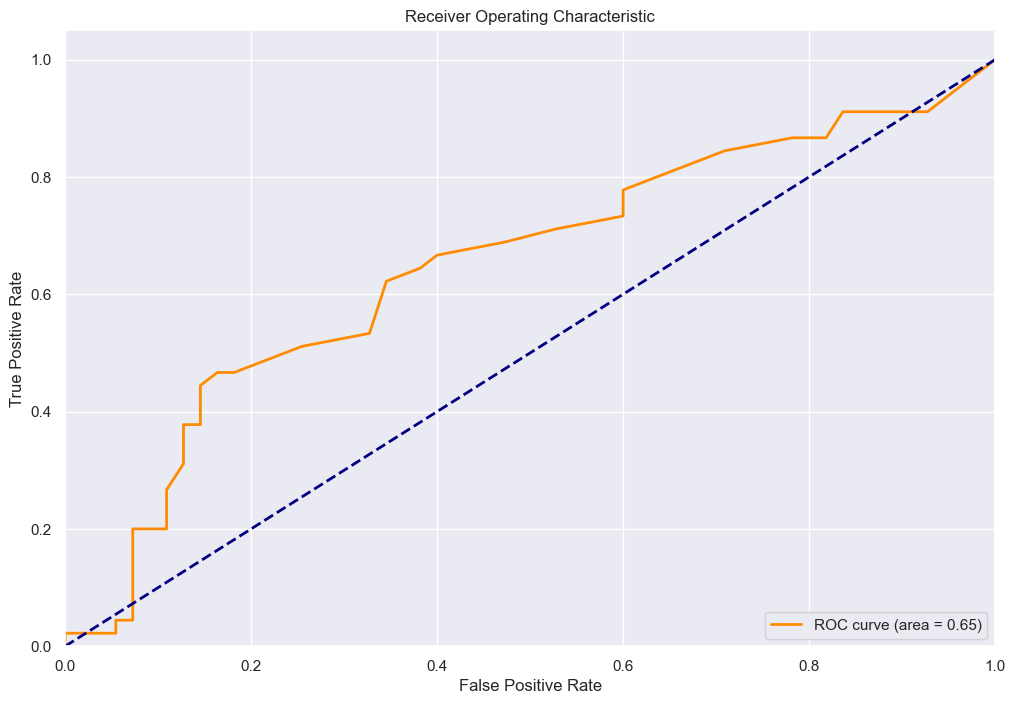

In [189]:
from sklearn.metrics import roc_curve, auc

# Predict the probabilities using the regularized model
predicted_probabilities = regularized_results_with_weights.predict(X_adjusted_with_const)

# Ensure 'outcome_adjusted' is in the correct format (binary 0/1)
if np.array_equal(outcome_adjusted.unique(), [0, 1]):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(outcome_adjusted, predicted_probabilities)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


In evaluating the predictive accuracy of our binary classification model, the Receiver Operating Characteristic (ROC) curve and the corresponding Area Under the Curve (AUC) were employed as primary metrics. The model achieved a ROC-AUC score of 0.6608. This score indicates a moderate ability of the model to discriminate between the two classes, surpassing the baseline of 0.5, which represents a model with no discriminative power equivalent to random guessing.

The score implies that in approximately 66.08% of cases, the model correctly ranks a randomly selected positive instance higher than a randomly selected negative instance. While this indicates a better-than-random capability in distinguishing between classes, it also reflects considerable room for improvement. The current performance may be deemed acceptable or inadequate depending on the specific application and standards in the relevant field.

The regularized model provides a more conservative and potentially more generalizable set of predictions, but it sacrifices some of the explanatory power seen in the original GLM.

To translate the logistic regression coefficients into percentage changes, we need to understand the interpretation of these coefficients. In logistic regression, the coefficients represent the change in the log-odds of the dependent variable for a one-unit increase in the predictor variable. To convert these log-odds into percentage changes, we use the following formula:

\[ \text{Percentage Change} = (e^{\text{Coefficient}} - 1) \times 100\% \]

This formula calculates the percentage change in the odds of the dependent variable occurring for a one-unit increase in the predictor variable.

Percentage changes for each coefficient, excluding the intercept:

- **ever_tbi_w_loc_clean**: A one-unit increase in 'ever_tbi_w_loc_clean' is associated with a 28.79% increase in the odds of the dependent variable occurring.
- **sex_clean**: A one-unit increase in 'sex_clean' is associated with a 39.35% increase in the odds of the dependent variable occurring.
- **apo_e4_allele_clean**: A one-unit increase in 'apo_e4_allele_clean' is associated with a 249.29% increase in the odds of the dependent variable occurring.
- **cerad**: A one-unit increase in 'cerad' is associated with a 57.55% increase in the odds of the dependent variable occurring.
- **education_years_stages_bin**: A one-unit increase in 'education_years_stages_bin' is associated with a 25.77% decrease in the odds of the dependent variable occurring.
- **age_at_first_tbi_bin**: A one-unit increase in 'age_at_first_tbi_bin' is associated with a 28.08% increase in the odds of the dependent variable occurring.
- **longest_loc_duration_bin**: A one-unit increase in 'longest_loc_duration_bin' is associated with a 2.46% decrease in the odds of the dependent variable occurring.


## Watermark

In [190]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [191]:
%watermark

Last updated: 2023-12-09T21:39:04.786135+01:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.16.1

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [192]:
%watermark --iversions

numpy      : 1.26.1
matplotlib : 3.8.0
seaborn    : 0.13.0
pandas     : 2.1.1
statsmodels: 0.14.0



-----


## Snapshot

In [193]:
today = date.today()
output_file = f"{ROOT_PATH}{PATH_HTML}{today}_{notebook_name}.html"
input_file = f"{notebook_name}.ipynb"
print(input_file)
!jupyter nbconvert --to html {input_file} --output {output_file}

03.02_causal_inference-modelling.ipynb
[NbConvertApp] Converting notebook 03.02_causal_inference-modelling.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 810944 bytes to ../reports/html/2023-12-09_03.02_causal_inference-modelling.html


In [194]:
# Construct the output file path
output_file = f"{ROOT_PATH}{PATH_HTML}{today}_{notebook_name}_no_code.html"

# Construct the input file path
input_file = f"{notebook_name}.ipynb"

# Convert the notebook to HTML without the code cells
os.system(f"jupyter nbconvert --to html {input_file} --output {output_file} --no-input")

[NbConvertApp] Converting notebook 03.02_causal_inference-modelling.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 707630 bytes to ../reports/html/2023-12-09_03.02_causal_inference-modelling_no_code.html


0